In [406]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import rotate

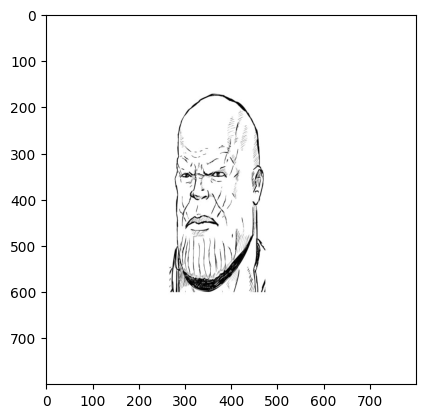

In [407]:
# Load Image

img = cv2.imread("Thanos-1.jpg", cv2.IMREAD_GRAYSCALE)
size = img.shape[0] # Square Image
plt.imshow(img, cmap='gray')

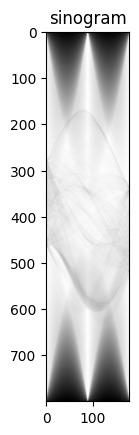

In [408]:
# Convert Image to Sinogram
angles = np.arange(1,181) # you can change the step
sinogram_img = np.zeros((size, len(angles)), dtype=np.float32) # every column is the detector signal from a view angle

for i in range(180):
    # rotate the image by counterclockwise so the x-ray is clockwise relevantly
    # projection is basically summing over columns
    sinogram_img[:,i] = rotate(img, angles[i]).sum(axis=0)

plt.imshow(sinogram_img, cmap='gray')
plt.title('sinogram')
plt.show()

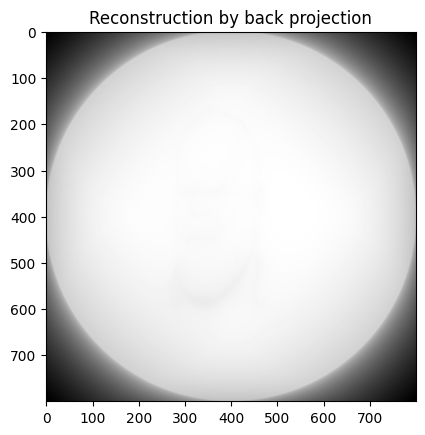

In [409]:
# reconstruct CT image from sinogram, sinogram_img (800, 180), using backward projection
reconstructed = np.zeros((size, size), dtype=np.float32)

for i in range(180):
    temp = np.tile(sinogram_img[:,i], (size, 1))
    temp = rotate(temp, -angles[i])
    reconstructed += temp

# normalize image between 0 and 255
reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min()) * 255

# show image
plt.imshow(reconstructed, cmap='gray')
plt.title('Reconstruction by back projection')
plt.show()

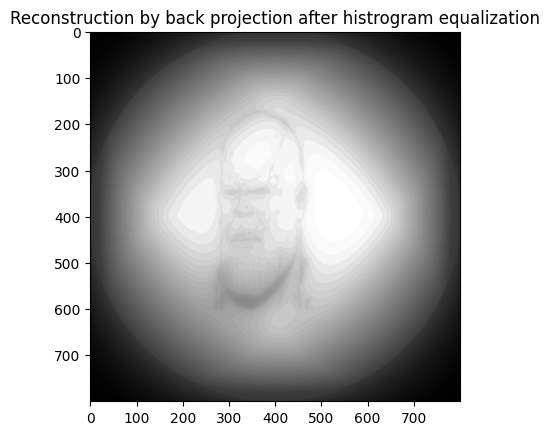

In [410]:
# apply histogram equalization to reconstructed image
reconstructed = cv2.equalizeHist(reconstructed.astype(np.uint8))

# show image
plt.imshow(reconstructed, cmap='gray')
plt.title('Reconstruction by back projection after histrogram equalization')
plt.show()

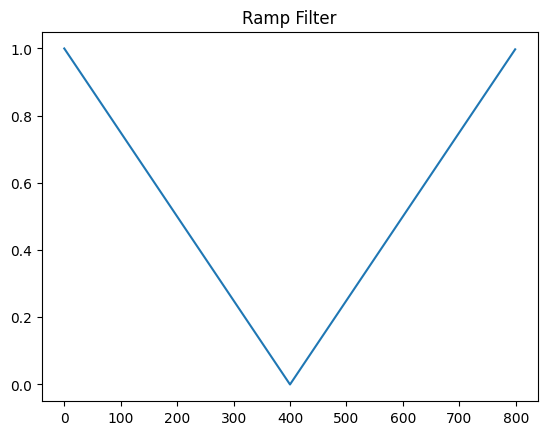

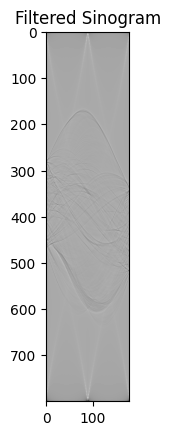

In [411]:
# apply ramp filtering (high pass filter) to sinogram_img

# create ramp filter
ramp_filter1 = np.arange(1, 0, -0.0025)
ramp_filter2 = np.arange(0, 1, 0.0025)
ramp_filter = np.concatenate((ramp_filter1, ramp_filter2))
#ramp_filter = np.append(ramp_filter, 1.)
# show ramp filter
plt.plot(ramp_filter)
plt.title('Ramp Filter')
plt.show()

filtered = np.zeros((size, len(angles)), dtype=np.float32)
for i in range(180):
    # calculate fft
    currentProjFFT = np.fft.fft(sinogram_img[:,i])
    # shift zero frequency component
    currentProjFFT = np.fft.fftshift(currentProjFFT)
    # apply filter
    currentProjFFTFiltered = currentProjFFT * ramp_filter
    # inverse shift zero frequency component
    currentProjFFTFiltered = np.fft.ifftshift(currentProjFFTFiltered)
    # inverse fft
    currentProjFFTFilteredInverse = np.fft.ifft(currentProjFFTFiltered)
    # save filtered sinogram
    filtered[:,i] = currentProjFFTFilteredInverse.real

# show filtered sinogram
plt.imshow(filtered, cmap='gray')
plt.title('Filtered Sinogram')
plt.show()


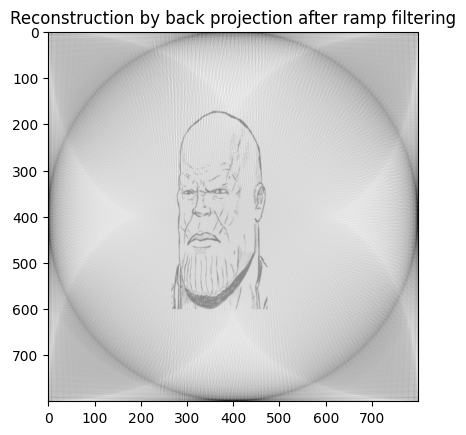

In [412]:
# perform back projection on filtered sinogram
filtered_reconstructed = np.zeros((size, size), dtype=np.float32)

for i in range(180):
    temp = np.tile(filtered[:,i], (size, 1))
    temp = rotate(temp, -angles[i])
    filtered_reconstructed += temp

# normalize image between 0 and 255
filtered_reconstructed = (filtered_reconstructed - filtered_reconstructed.min()) / (filtered_reconstructed.max() - filtered_reconstructed.min()) * 255

# show image
plt.imshow(filtered_reconstructed, cmap='gray')
plt.title('Reconstruction by back projection after ramp filtering')
plt.show()

Part 6: Black rows in the original sinogram causes the filtered back projection of it to have fragmented rings and curves. These curves cause blurs and blendings in the image. The location of these curves correspond to the damaged row in the sinogram.

Part 7: Similarly, black columns in the original sinogram causes the filtered back projection of it to have streaks that blurr the image. Rather than blurring curves, the streaks are linear and stretch the image. The location of these streaks correspond to the damaged row in the sinogram.